<center><h1>Alignment Jam : The Interpretability Hackathon</h1></center>

## Import main packages

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import time
import random

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, AveragePooling2D, Activation

from keras import Sequential

from syngular.layers.TensorDense import TensorDense

import matplotlib.pyplot as plt

##### Tensorflow Keras Visualisation package for GradCAM and SmoothGrad visualisation

In [4]:
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import CategoricalScore


## Reproductibility

In [5]:
seed_value = 13112022

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [7]:
batch_size = 512

## Data processing

In [6]:
def normalize_img(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return tf.cast(image, tf.float32) / 255., label

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [9]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Simple Convolutional Neural Network for Cifar10

In [10]:
def cifar_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model_nn = cifar_model()

model_nn.summary()

model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [11]:
history_tn = model_nn.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test
)

Epoch 1/50


C:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


98/98 [==============================] - 22s 70ms/step - loss: 2.1267 - acc: 0.3353 - val_loss: 2.3222 - val_acc: 0.2411
Epoch 2/50
98/98 [==============================] - 4s 42ms/step - loss: 1.4828 - acc: 0.4877 - val_loss: 2.1533 - val_acc: 0.3159
Epoch 3/50
98/98 [==============================] - 4s 42ms/step - loss: 1.2246 - acc: 0.5695 - val_loss: 1.6004 - val_acc: 0.4565
Epoch 4/50
98/98 [==============================] - 4s 43ms/step - loss: 1.0766 - acc: 0.6225 - val_loss: 1.1578 - val_acc: 0.5959
Epoch 5/50
98/98 [==============================] - 4s 42ms/step - loss: 0.9825 - acc: 0.6563 - val_loss: 0.9482 - val_acc: 0.6667
Epoch 6/50
98/98 [==============================] - 4s 42ms/step - loss: 0.9087 - acc: 0.6837 - val_loss: 0.8680 - val_acc: 0.6965
Epoch 7/50
98/98 [==============================] - 4s 43ms/step - loss: 0.8582 - acc: 0.7014 - val_loss: 0.8412 - val_acc: 0.7055
Epoch 8/50
98/98 [==============================] - 4s 43ms/step - loss: 0.8025 - acc: 0.7206

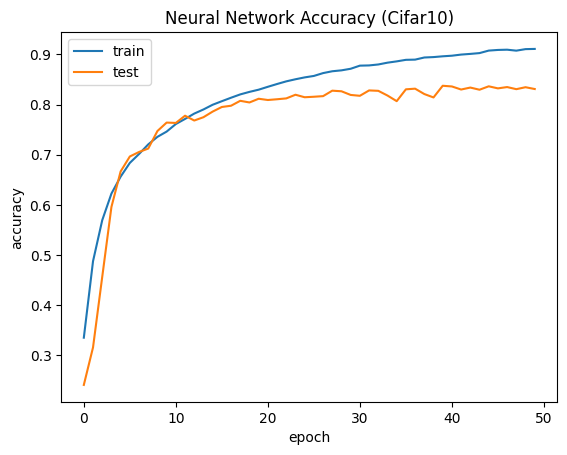

In [52]:
plt.plot(history_tn.history['acc'])
plt.plot(history_tn.history['val_acc'])
plt.title('Neural Network Accuracy (Cifar10)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

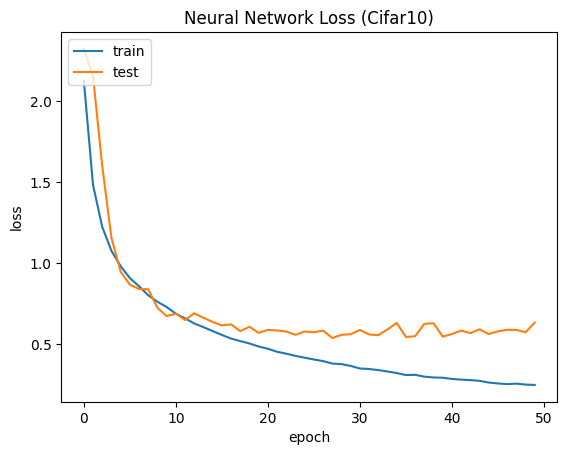

In [91]:
plt.plot(history_tn.history['loss'])
plt.plot(history_tn.history['val_loss'])
plt.title('Neural Network Loss (Cifar10)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualisation

In [12]:
images = list(ds_train)

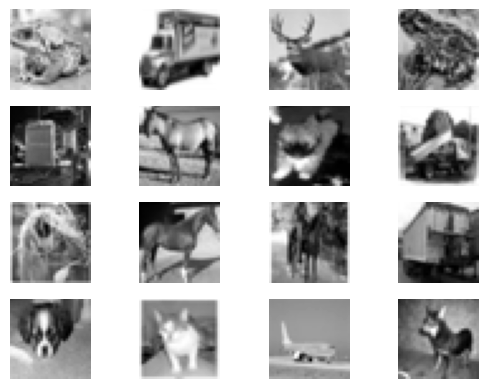

In [96]:
batch_imgs = images[0][0][64:64+16]
batch_labels = list(images[0][1][64:64+16].numpy())

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(batch_imgs[i].numpy().reshape(32,32), cmap='gray')
    plt.axis('off')

In [97]:
replace2linear = ReplaceToLinear()

In [98]:
score = CategoricalScore(batch_labels)
activation_maximization = ActivationMaximization(model_nn, model_modifier=replace2linear, clone=True)

In [99]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model_nn, model_modifier=replace2linear, clone=True)
cam = gradcam(score, batch_imgs, penultimate_layer=-1)

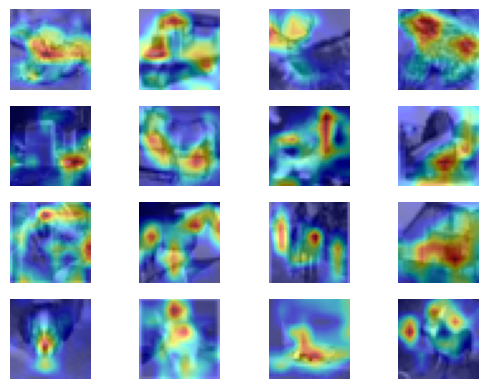

In [100]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(batch_imgs[i].numpy().reshape(32,32), cmap='gray')
    plt.imshow(cam[i], cmap='jet', alpha=0.5)
    plt.axis('off')

In [101]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model_nn, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, batch_imgs, smooth_samples=20, smooth_noise=0.20)


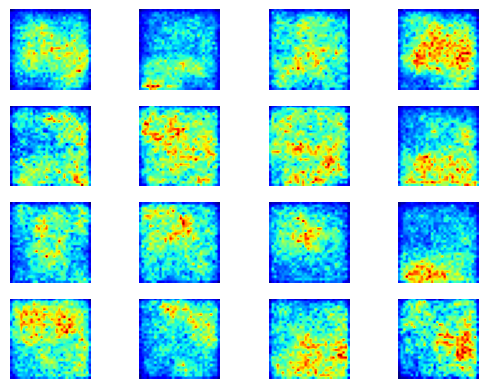

In [102]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(saliency_map[i], cmap='jet')
    plt.axis('off')

In [103]:
frogs = []
i = 0

while len(frogs) < 16:
    if images[0][1][i] == 6:
        frogs.append(images[0][0][i])
    i += 1
frogs = np.array(frogs)

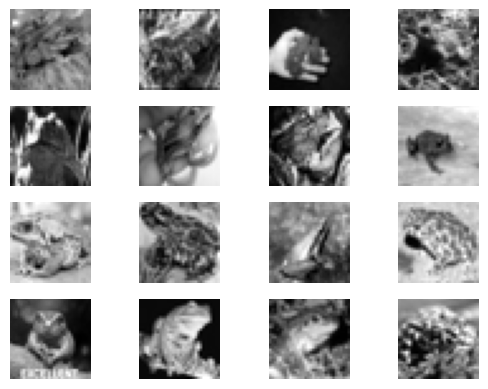

In [104]:

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(frogs[i].reshape(32,32), cmap='gray')
    plt.axis('off')

In [105]:
score = CategoricalScore([6] * 16)
activation_maximization = ActivationMaximization(model_nn, model_modifier=replace2linear, clone=True)

In [106]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model_nn, model_modifier=replace2linear, clone=True)
cam = gradcam(score, frogs, penultimate_layer=-1)

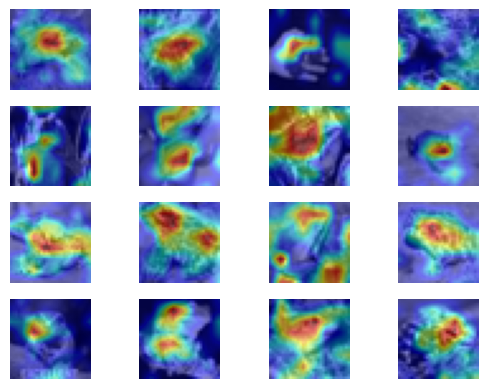

In [107]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(frogs[i].reshape(32,32), cmap='gray')
    plt.imshow(cam[i], cmap='jet', alpha=0.5)
    plt.axis('off')

In [108]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model_nn, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, frogs, smooth_samples=20, smooth_noise=0.20)


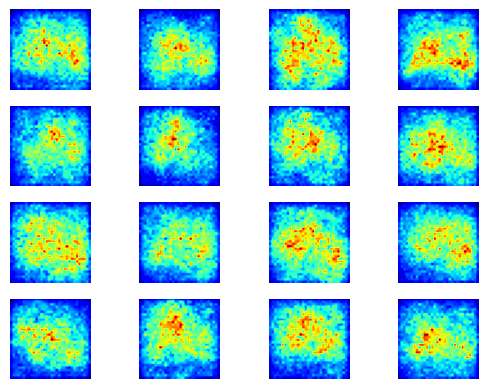

In [109]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(saliency_map[i], cmap='jet')
    plt.axis('off')